# Introduction

A **time series** is a time-oriented or chronological sequence of observations on a variable of interest. Formally, a time series is a collection of random variables ordered according to the time instant at which they are collected: $\{y_1, y_2, ...\}$, where $y_i$ denotes the value of the random variable at time $i$. Therefore, a time series is a realization of a stochastic process $\{y_t\}$, $t=1,2,...$. 

#TODO: describe contents of the notebook

### Package imports

In [94]:
# data handling
import pandas as pd
import numpy as np

# time series handling
from sktime.datasets import load_airline

# visualization
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Time series examples

1. **Economic time series**

Examples of economic time series include share prices on successive days, average incomes in successive months, company profits in succesive years, etc. 

Below is the classic Beveridge wheat price index series, which represents the average wheat price of almost 50 different locations from the year 1500 to 1869.

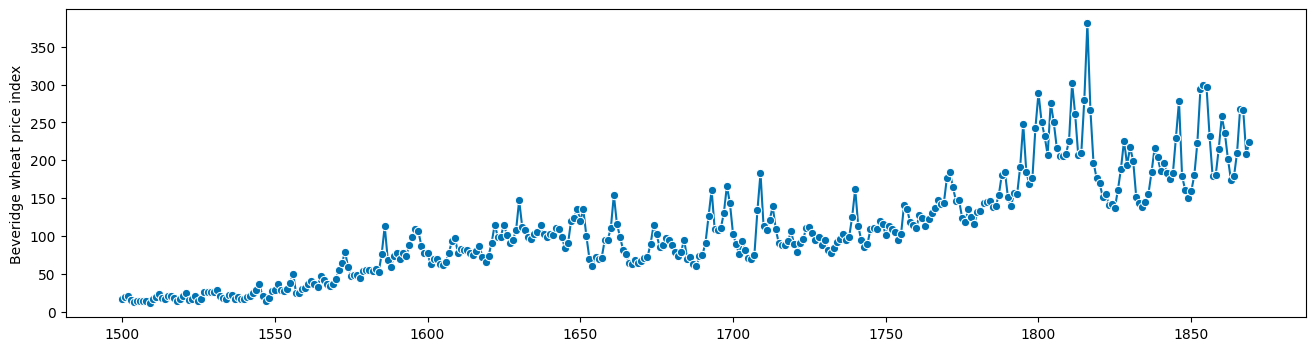

In [61]:
beveridge = pd.read_csv('..\data\\beveridge.csv', index_col=0)
beveridge = pd.Series(beveridge['Beveridge wheat price index'])
plot_series(beveridge) # plot series
plt.show()

2. **Physical time series**

Some time series are generated by physical processes, such as meteorological or geophysical phenomena. Examples are rainfall on successive days, air temperature measured in successive hours, days or months. 

The figure below shows deviations of global mean land-ocean temperature index from 1880 to 2009 from the 1951-1980 temperature average. There has been an upward trend since the end of the 20th century, which has been used as an argument in favor of climate change. 

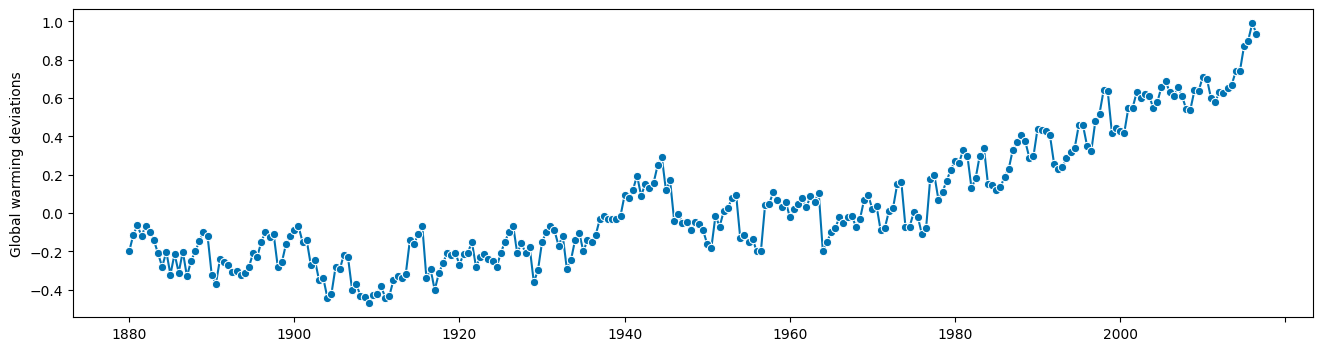

In [93]:
global_warming = pd.read_csv('..\data\\global_warming_deviations.csv', index_col=0)
global_warming = pd.Series(global_warming['Global warming deviations'])
plot_series(global_warming)
plt.show()

3. **Marketing time series**

A problem of interest in commerce is the analysis of sales in successive days, weeks or months. Knowing past sales can help to forecast or estimate the number of future sales to prepare the warehouse or prepare budgets.

The time series below corresponds to the sales volumes of anti-diabetic drugs in Australia, collected by month. The data were used to forecast the annual budget for the Pharmaceutical Benefit Scheme (PBS) by the Australian Government.

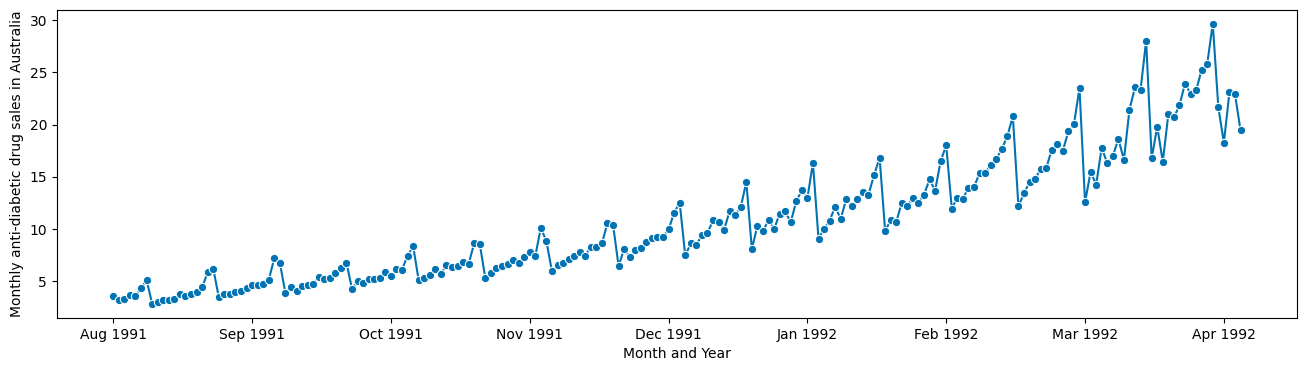

In [143]:
antidiabetic_sales = pd.read_csv('..\data\Monthly_anti-diabetic_drug_sales_in_Australia_from_1991_to_2008.csv', index_col=0, parse_dates=['Date'])
antidiabetic_sales = pd.Series(antidiabetic_sales['Monthly anti-diabetic drug sales in Australia'])
fig, ax = plot_series(antidiabetic_sales)
ax.set_xticklabels(antidiabetic_sales.index.strftime('%b %Y'))
ax.set_xlabel('Month and Year')
plt.show()

# Data: Air passegenger bookings

To ilustrate

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

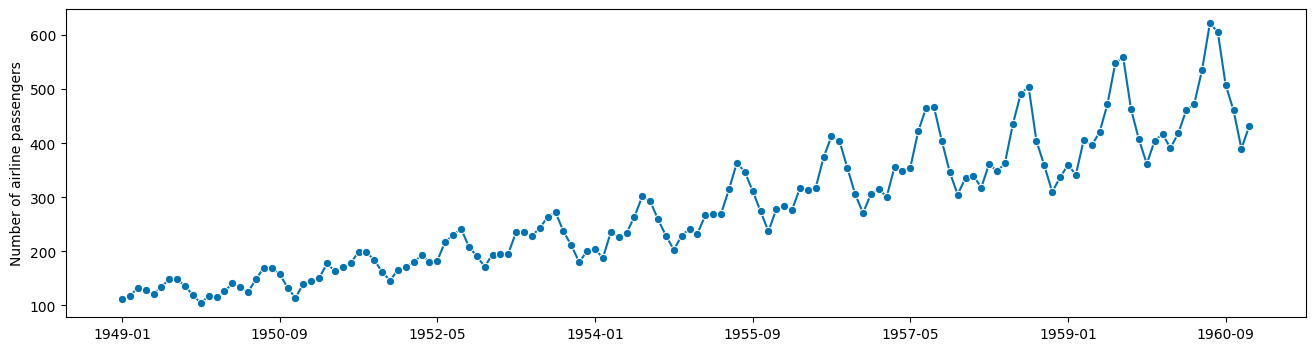

In [9]:
y = load_airline()
plot_series(y)

In [10]:
y

1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64